<a href="https://colab.research.google.com/github/linhnk597/NLP-SentimentalAnalysis/blob/main/Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and datasets

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#Setting working directory
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Shopee Code League/Sentimental Analysis

#Import training dataset (df)
train_df = pd.read_csv("train.csv",index_col=False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Shopee Code League/Sentimental Analysis


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train_df.head(3)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ


In [7]:
train_df.shape

(34660, 21)

# EDA 


**Keep only necessary columns**

In [8]:
cols=["reviews.rating","reviews.text"]
train_df=train_df[cols]
train_df.columns =['rating', 'text'] 
train_df.shape

(34660, 2)

**Check NULL values**

- NULL in rating -> test set
- Null in text -> drop


In [9]:
train_df.isnull().sum()

rating    33
text       1
dtype: int64

In [10]:
train_df.dropna(subset=["text"],inplace=True)
print(train_df.isnull().sum())
print(train_df.shape)

rating    33
text       0
dtype: int64
(34659, 2)


In [11]:
test_df=train_df[train_df.isnull().any(axis=1)]
test_df.shape

(33, 2)

In [12]:
train_df.dropna(inplace=True)
train_df.shape

(34626, 2)

**Create review_positive column**

- Rating >= 4 -> 1 else 0

**Drop rating column**

In [13]:
train_df["positive"]=np.where(train_df['rating']>=4,1,0)
train_df.drop("rating",inplace=True,axis=1)
train_df.head(3)

,text,positive
0,This product so far has not disappointed. My c...,1
1,great for beginner or experienced person. Boug...,1
2,Inexpensive tablet for him to use and learn on...,1


In [14]:
test_df.drop("rating",axis=1,inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Check review_positive distribution**

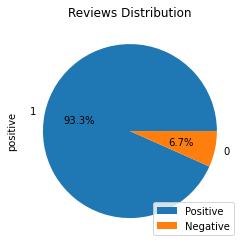

In [15]:
train_df['positive'].value_counts().plot(kind='pie',autopct='%1.1f%%', title="Reviews Distribution")
plt.legend(("Positive","Negative"),loc="lower right")

# Cleaning texts

In [16]:
import re
from textblob import TextBlob
import nltk
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# # In case of any corpus are missing 
# download all-nltk
#nltk.download()
stop_words = stopwords.words("english")
stop_words.remove("not")
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = str(sentence)
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = sentence.lower()
    #sentence = ' '.join([word for word in sentence.split(' ') if word not in set(stop_words)])
    sentence = sentence.split()
    ps= PorterStemmer()
    sentence=[ps.stem(word) for word in sentence if word not in set(stop_words)]
    sentence=" ".join(sentence)
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

train_df["Summary_Clean"] = train_df["text"].apply(cleanup)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:

corpus= list(train_df["Summary_Clean"])
corpus

['product far not disappoint children love use like abil monitor control content see eas',
 'great beginn experienc person ought gift love',
 'nexpens tablet use learn step e thrill learn kype alreadi',
 'ire two week love tablet great valu e rime ember tablet love abl easili access rime content well movi download watch later screen realli nice look nice crisp bright infact brighter ipad pro cost base model build fire run mm thick smooth glossi feel back realli amaz hold like futurist tab ur hand',
 'bought grand daughter come visit set user enter age name mazon make sure access site content appropri age impl love capabl also bought instal gig card give littl tablet plenti storag price think tablet best one ou spend hundr dollar addit speed capac come basic tablet everyth peopl ever need fraction cost',
 'amazon fire inch tablet perfect size purchas husband bigger screen phone e gotten one year ago knew would good purchas',
 'reat e read go nice light weight price point given definit w

# Creating Bag of Words model

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
#Problem: in Corpus, there are still redundant words (waitress, place, textur...) 
#Solution: take the most frequent words
#cv= CountVectorizer()
cv= CountVectorizer(max_features=9500) #After running line below  
#Fit the corpus to X, take all the words in corpus- put in different columns
X = cv.fit_transform(corpus).toarray()
#Create dependent variable
y= train_df["positive"].values

In [19]:
#Take the number of words
len(X[0])
#put back to cv

9500

# Splitting the dataset into Train and Validation set

**Splitting dataset**
- 20% validation - 80% train

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_val.shape,  y_val.shape)

Train set: (27700, 9500) (27700,)
Test set: (6926, 9500) (6926,)


**Oversampling**

- 20% negative - 80% positive

In [21]:
from imblearn.over_sampling import SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
oversample = SMOTE(sampling_strategy=0.2,random_state=42)
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Before OverSampling, counts of label '1': 25824
Before OverSampling, counts of label '0': 1876 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After OverSampling, the shape of train_X: (30988, 9500)
After OverSampling, the shape of train_y: (30988,) 

After OverSampling, counts of label '1': 25824
After OverSampling, counts of label '0': 5164


# Building Text sentimental Analysis models

**Naive Bayes**

In [23]:
#NB GaussianNB
from sklearn.naive_bayes import GaussianNB
NB_gau_model = GaussianNB()
NB_gau_model.fit(X_train_res,y_train_res)

GaussianNB(priors=None, var_smoothing=1e-09)

In [22]:
#NB Bernouli
from sklearn.naive_bayes import BernoulliNB
NB_ber_model = BernoulliNB()
NB_ber_model.fit(X_train_res,y_train_res)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [24]:
#NB Multinormial
from sklearn.naive_bayes import MultinomialNB
NB_mul_model = MultinomialNB()
NB_mul_model.fit(X_train_res,y_train_res)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Predicting with validation set and evaluating the results

**Criteria:**
- ROC/ AUC
- Confusion Matrix
- Accuracy


In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve

[[ 296  139]
 [4544 1947]]
0.32385215131388967


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


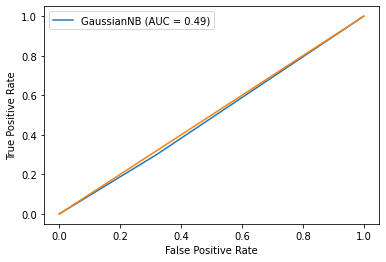

In [26]:
y_pred1=NB_gau_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred1)
print(cm)
print(accuracy_score(y_val, y_pred1))
plot_roc_curve(NB_gau_model,X_val,y_val)
sns.lineplot([0,1],[0,1])


[[ 164  271]
 [ 501 5990]]
0.8885359514871499


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


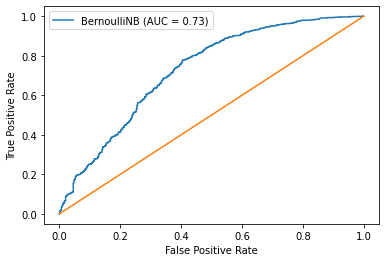

In [27]:
y_pred2=NB_ber_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred2)
print(cm)
print(accuracy_score(y_val, y_pred2))
plot_roc_curve(NB_ber_model,X_val,y_val)
sns.lineplot([0,1],[0,1])


[[ 211  224]
 [ 316 6175]]
0.9220329194340168


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


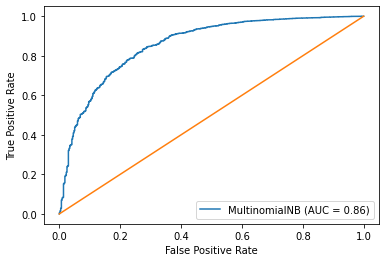

In [28]:
y_pred3=NB_mul_model.predict(X_val)
cm = confusion_matrix(y_val, y_pred3)
print(cm)
print(accuracy_score(y_val, y_pred3))
plot_roc_curve(NB_mul_model,X_val,y_val)
sns.lineplot([0,1],[0,1])


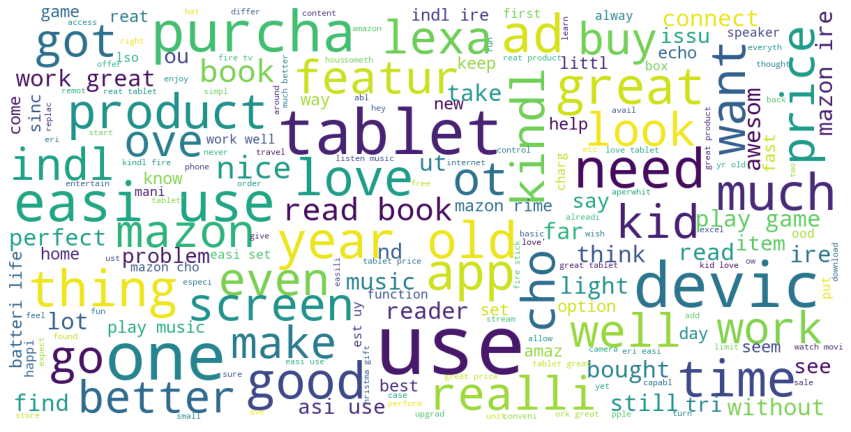

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib as mpl
stopwords = set(STOPWORDS)


mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(corpus)